<h1>Part 2: exploratory data analysis</h1>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import swifter
import nltk
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment import SentimentIntensityAnalyzer  

**Step 1: loading the cleaned dataset**

In [2]:
df = pd.read_csv("train_cleaned.csv")

**Step 2: feature engineering and feature distribution analysis** <br>
First we create the column Word_Count containg the number of words in the review, then we 
define Review_Length as the number of characters in a review.

In [3]:
df["Review"] = df["Review"].astype(str)
df['Review_Length'] = df['Review'].apply(len)
df['Word_Count'] = df['Review'].apply(lambda x: len(x.split()))

Visualising the distribution of ratings.

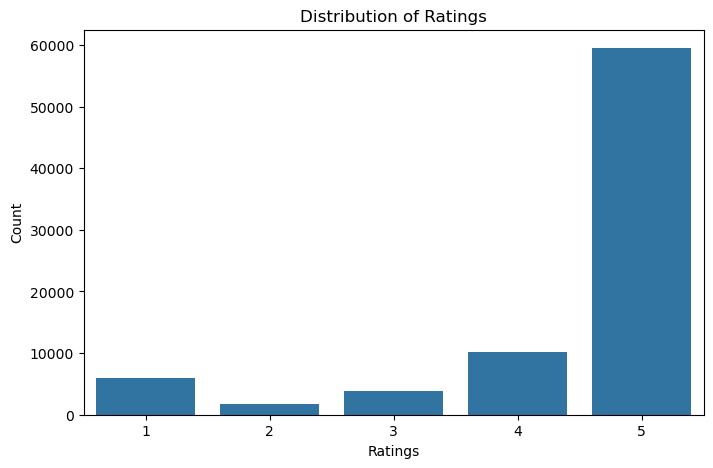

In [4]:
plt.figure(figsize=(8,5))
sns.countplot(x=df['Ratings'])
plt.title('Distribution of Ratings')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

The data is heavily skewed towards 5. In that case, we consider using SMOTE in the future.
Now we check the central tendencies and dispersion.

In [5]:
df.describe()

,Ratings,Review_Length,Word_Count
count,81245.000000,81245.000000,81245.000000
mean,4.421491,46.632519,7.644864
std,1.162991,60.401338,9.403311
min,1.000000,1.000000,1.000000
25%,4.000000,13.000000,2.000000
50%,5.000000,27.000000,5.000000
75%,5.000000,55.000000,9.000000
max,5.000000,3038.000000,571.000000


Both Review_Length and Word_Count have severe outliers, which we promptly discard (we checked various quantiles, but kept only the 95th for readibility's sake).

In [6]:
review_length_95th = df['Review_Length'].quantile(0.95)
word_count_95th = df['Word_Count'].quantile(0.95)

df_filtered = df[(df['Review_Length'] <= review_length_95th) & (df['Word_Count'] <= word_count_95th)]

df_filtered.describe()

,Ratings,Review_Length,Word_Count
count,77011.000000,77011.000000,77011.000000
mean,4.450403,35.765527,6.000714
std,1.135795,31.745947,5.086463
min,1.000000,1.000000,1.000000
25%,4.000000,13.000000,2.000000
50%,5.000000,25.000000,4.000000
75%,5.000000,48.000000,8.000000
max,5.000000,160.000000,26.000000


Let's explore how review length and word count are related to the rating.

Text(0, 0.5, 'Review Length')

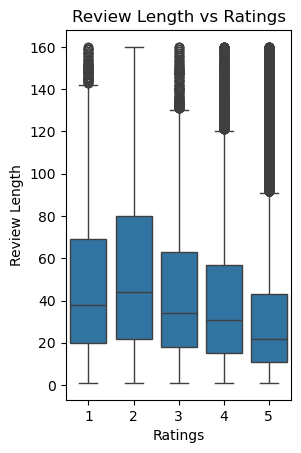

In [7]:
plt.subplot(1, 2, 1)
sns.boxplot(x='Ratings', y='Review_Length', data=df_filtered)
plt.title('Review Length vs Ratings')
plt.xlabel('Ratings')
plt.ylabel('Review Length')

Clearly, longer reviews tend to be more negative.

Text(0, 0.5, 'Word Count')

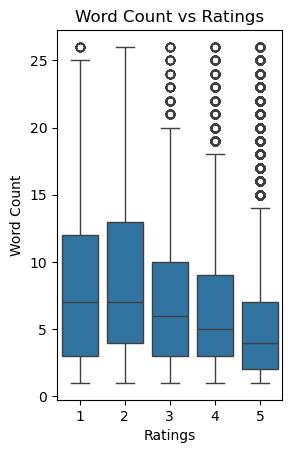

In [8]:
plt.subplot(1, 2, 2)
sns.boxplot(x='Ratings', y='Word_Count', data=df_filtered)
plt.title('Word Count vs Ratings')
plt.xlabel('Ratings')
plt.ylabel('Word Count')

The box plot is analogical, hence, let's check the correlations.

In [ ]:
pearson_corr = df['Review_Length'].corr(df['Word_Count'], method='pearson')

spearman_corr = df['Review_Length'].corr(df['Word_Count'], method='spearman')

print(f"Pearson Correlation: {pearson_corr}")
print(f"Spearman Correlation: {spearman_corr}")

Pearson Correlation: 0.9862851825301413
Spearman Correlation: 0.9780841819395664


The correlations are very high; thus, we will use only Review_Length in the model.<br>
Let's see which words appear most often in reviews with some arbitrary rating $i, \ i = 1, ..., 5$. <br>
**Defining the function pulling the most frequent words for rating i**

In [9]:
vectorizer = CountVectorizer()

def get_most_frequent_words(df, rating):
    reviews = df[df['Ratings'] == rating]['Review']
    
    X = vectorizer.fit_transform(reviews)
    
    word_count = X.sum(axis=0).A1
    
    words = vectorizer.get_feature_names_out()
    
    word_freq = pd.DataFrame({'Word': words, 'Count': word_count})
    
    word_freq = word_freq.sort_values(by='Count', ascending=False)
    
    return word_freq.head(10)

most_frequent_words = {}
for i in range(1, 6):
    most_frequent_words[i] = get_most_frequent_words(df, i)

**Plotting the results**

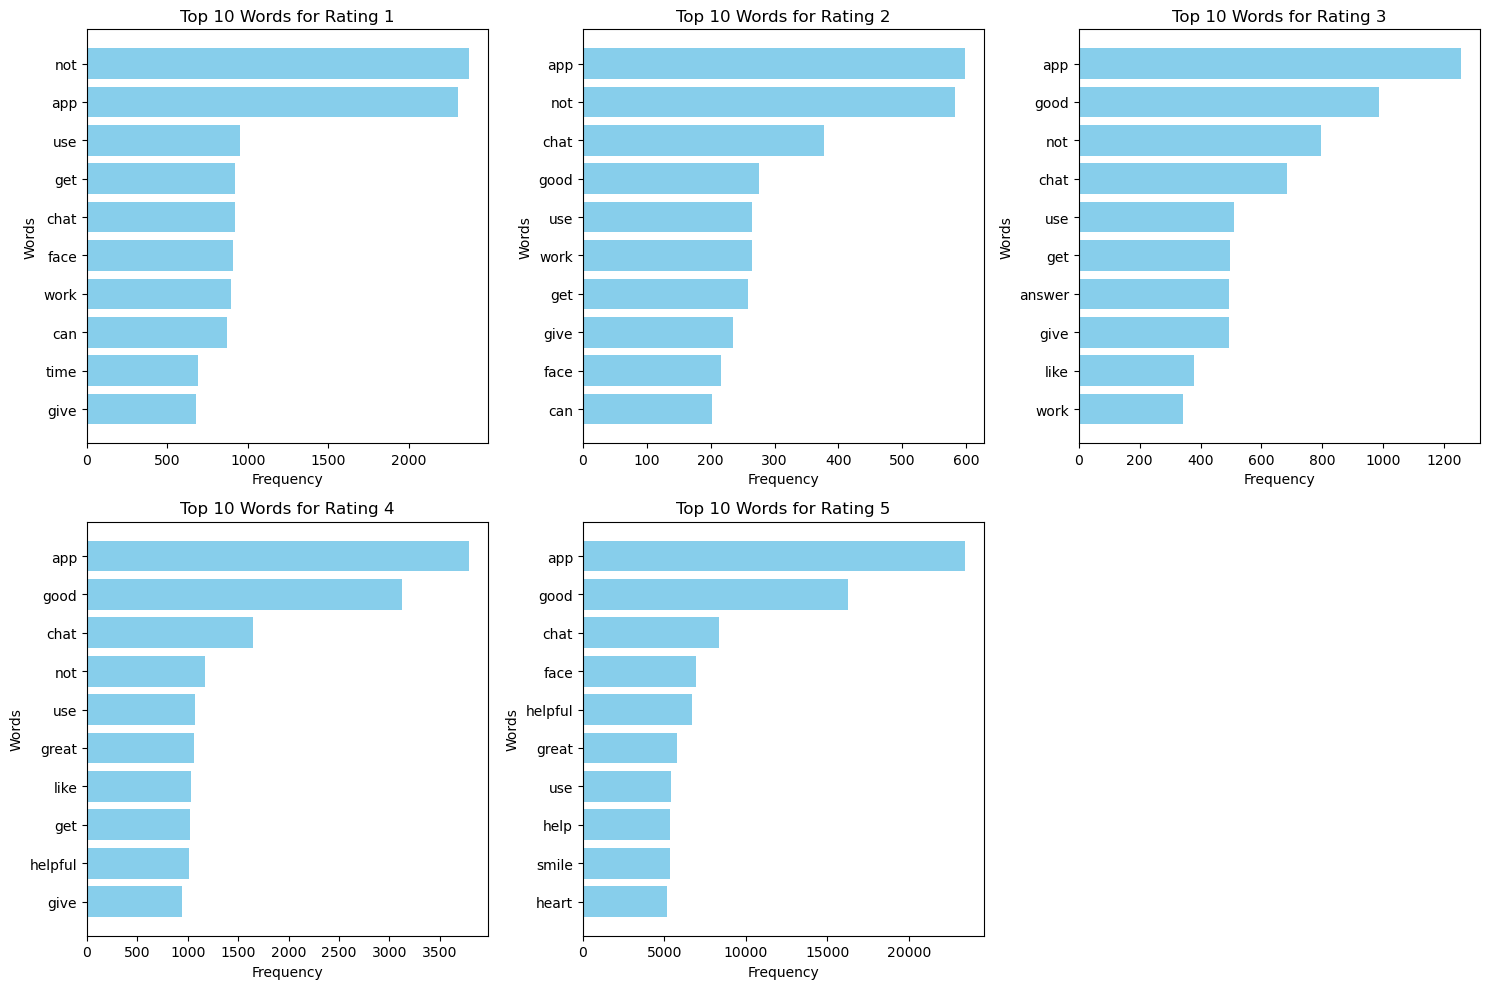

In [10]:
def plot_most_frequent_words(most_frequent_words):
    plt.figure(figsize=(15, 10))
    
    for i in range(1, 6):
        words = most_frequent_words[i]['Word']
        counts = most_frequent_words[i]['Count']
        
        plt.subplot(2, 3, i)
        plt.barh(words, counts, color='skyblue')
        plt.title(f"Top 10 Words for Rating {i}")
        plt.xlabel('Frequency')
        plt.ylabel('Words')
        plt.gca().invert_yaxis()
    
    plt.tight_layout()
    plt.show()


plot_most_frequent_words(most_frequent_words)


We see that both "app" and "chat" are ubiquitous, hence not yielding any useful information. Therefore, we remove them from the reviews and renew the process of finding the most frequent words for each rating $i, \ i = 1, ..., 5$.

In [11]:
df['Review'] = df['Review'].str.replace(r'\b(chat|app)\b', '', regex=True, case=False)
df['Review'] = df['Review'].str.strip()

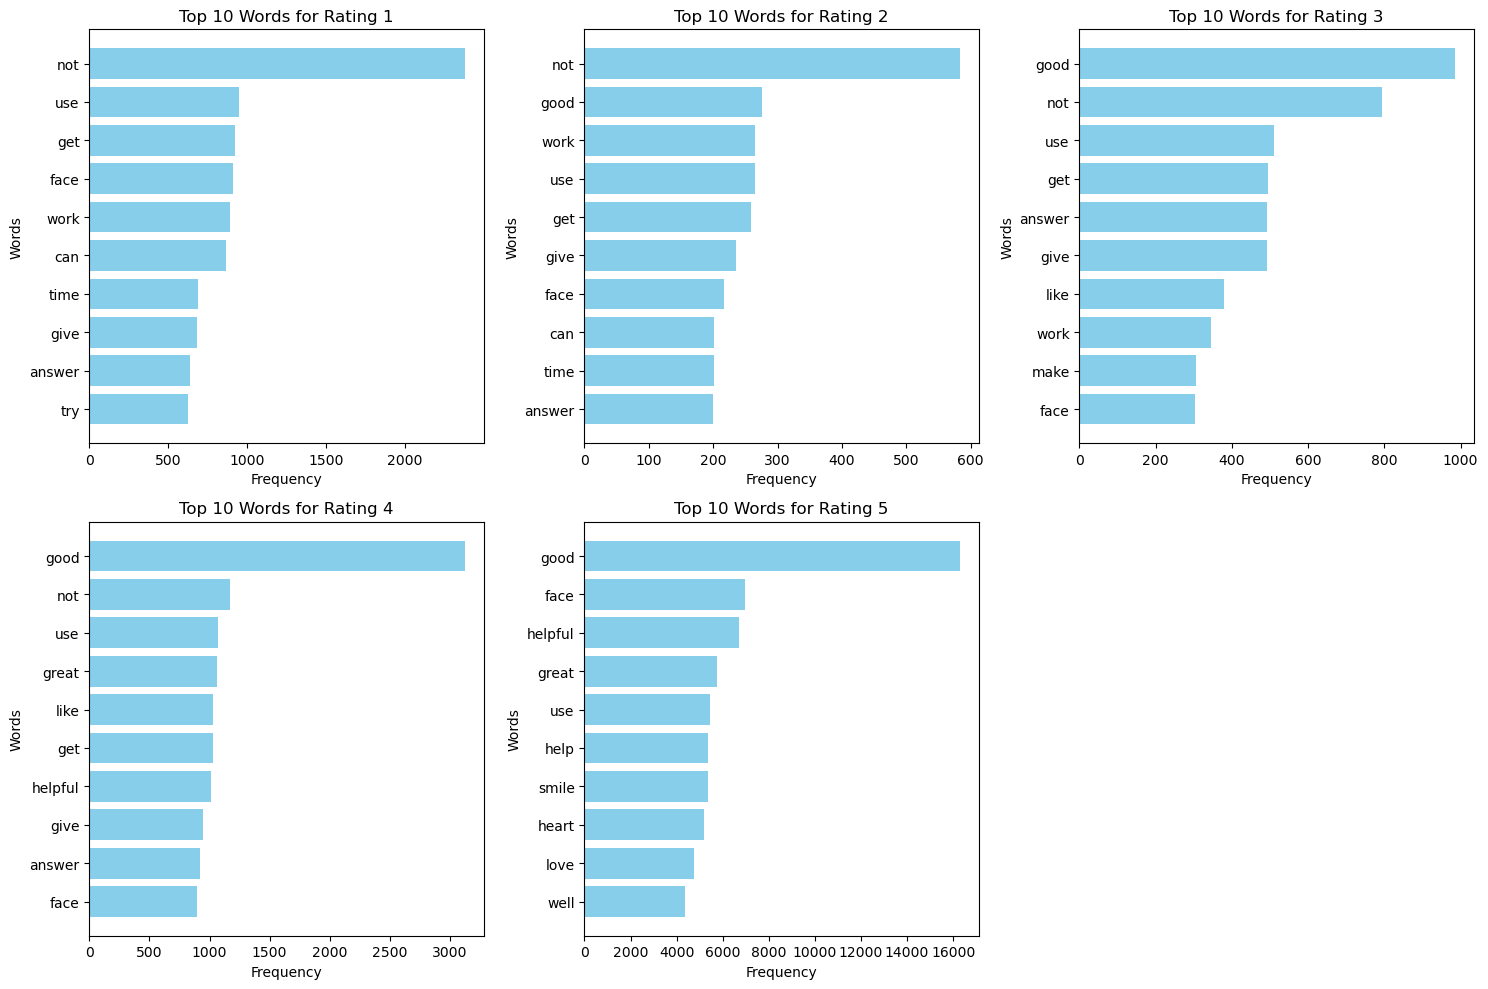

In [12]:
most_frequent_words = {}
for i in range(1, 6):
    most_frequent_words[i] = get_most_frequent_words(df, i)

plot_most_frequent_words(most_frequent_words)

"not" clearly dominates the negative reviews, whereas "good" dominates the average and positive reviews. This is consistent with intuition. <br>

Sentiment refers to the emotional tone expressed in a piece of text.
VADER (Valence Aware Dictionary and sEntiment Reasoner) is a sentiment analysis tool, which we use below and then plot the results.

In [13]:
# Run this only once!

# nltk.download('vader_lexicon')

Pandas Apply:   0%|          | 0/81245 [00:00<?, ?it/s]

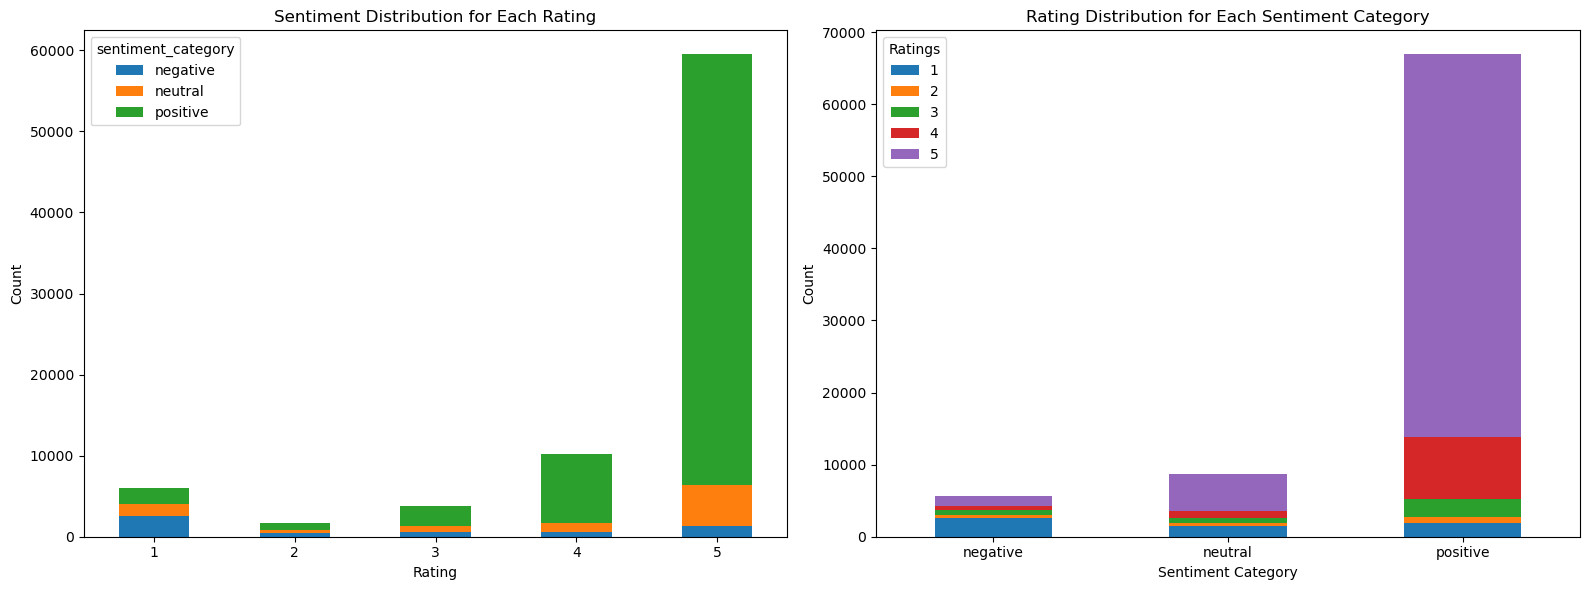

In [16]:
sia = SentimentIntensityAnalyzer()

df['sentiment'] = df['Review'].swifter.apply(lambda x: sia.polarity_scores(x)['compound'])

df['sentiment_category'] = pd.cut(df['sentiment'],
                                  bins=[-1, -0.05, 0.05, 1],
                                  labels=['negative', 'neutral', 'positive'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

df.groupby(['Ratings', 'sentiment_category']).size().unstack().plot(kind='bar', stacked=True, ax=ax1)
ax1.set_title('Sentiment Distribution for Each Rating')
ax1.set_ylabel('Count')
ax1.set_xlabel('Rating')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)

df.groupby(['sentiment_category', 'Ratings']).size().unstack().plot(kind='bar', stacked=True, ax=ax2)
ax2.set_title('Rating Distribution for Each Sentiment Category')
ax2.set_ylabel('Count')
ax2.set_xlabel('Sentiment Category')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

Contrary to intuition, approximately 1/3 of 1 star reviews are classified as having positive sentiment.<br>
On the other hand, as expected, approximately 1/2 of all negative reviews are 1 star.<br>

An N-gram is a sequence of N consecutive words from a given text. Below we check which N-grams appear most often in i star reviews, $i \in [5], \ N \in \{2,3\}$. 

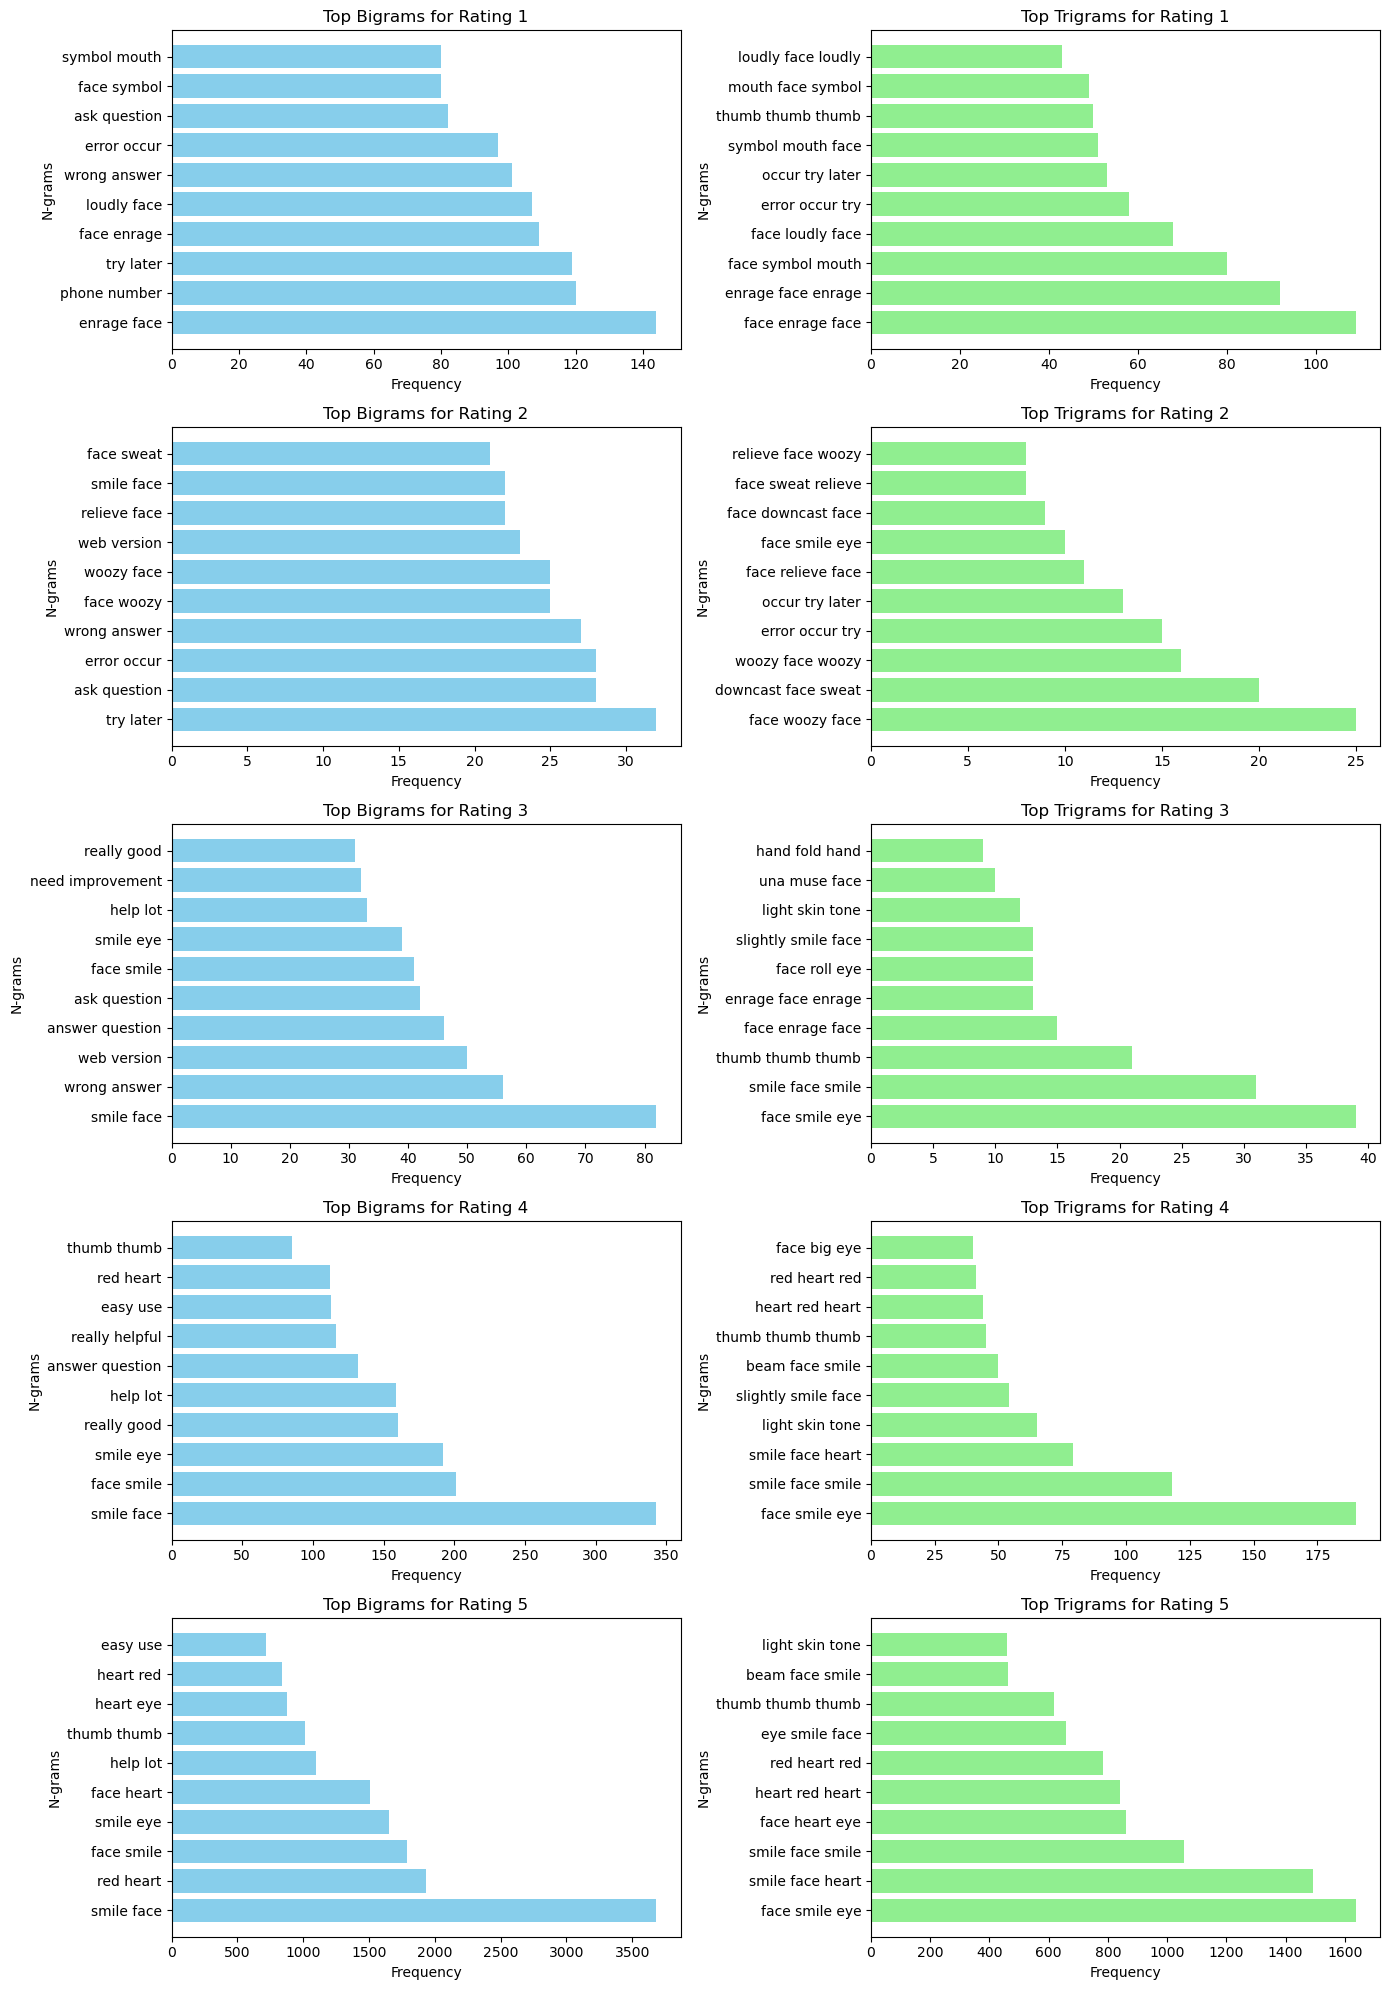

In [17]:
def get_top_ngrams(df, rating, ngram_range=(2, 3), top_n=10):
    reviews = df[df['Ratings'] == rating]['Review']
    
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english', max_features=top_n)
    X = vectorizer.fit_transform(reviews)
    
    ngrams = vectorizer.get_feature_names_out()
    freq = np.asarray(X.sum(axis=0)).flatten()
    
    ngram_df = pd.DataFrame(list(zip(ngrams, freq)), columns=['n-gram', 'Frequency'])
    return ngram_df.sort_values(by='Frequency', ascending=False)

top_ngrams = {}
for rating in range(1, 6):
    top_ngrams[rating] = {
        'Bigrams': get_top_ngrams(df, rating, ngram_range=(2, 2)),
        'Trigrams': get_top_ngrams(df, rating, ngram_range=(3, 3))
    }

fig, axes = plt.subplots(5, 2, figsize=(14, 20))

for rating in range(1, 6):
    bigrams = top_ngrams[rating]['Bigrams']
    axes[rating-1, 0].barh(bigrams['n-gram'], bigrams['Frequency'], color='skyblue')
    axes[rating-1, 0].set_title(f"Top Bigrams for Rating {rating}")
    axes[rating-1, 0].set_xlabel("Frequency")
    axes[rating-1, 0].set_ylabel("N-grams")
    
    trigrams = top_ngrams[rating]['Trigrams']
    axes[rating-1, 1].barh(trigrams['n-gram'], trigrams['Frequency'], color='lightgreen')
    axes[rating-1, 1].set_title(f"Top Trigrams for Rating {rating}")
    axes[rating-1, 1].set_xlabel("Frequency")
    axes[rating-1, 1].set_ylabel("N-grams")

plt.tight_layout()
plt.show()

Now we analyse Review Date vs Rating.

In [18]:
min_date = df['Review Date'].min()
max_date = df['Review Date'].max()

print(f"Minimum Review Date: {min_date}")
print(f"Maximum Review Date: {max_date}")

Minimum Review Date: 1/1/2024 0:06
Maximum Review Date: 9/9/2023 9:33


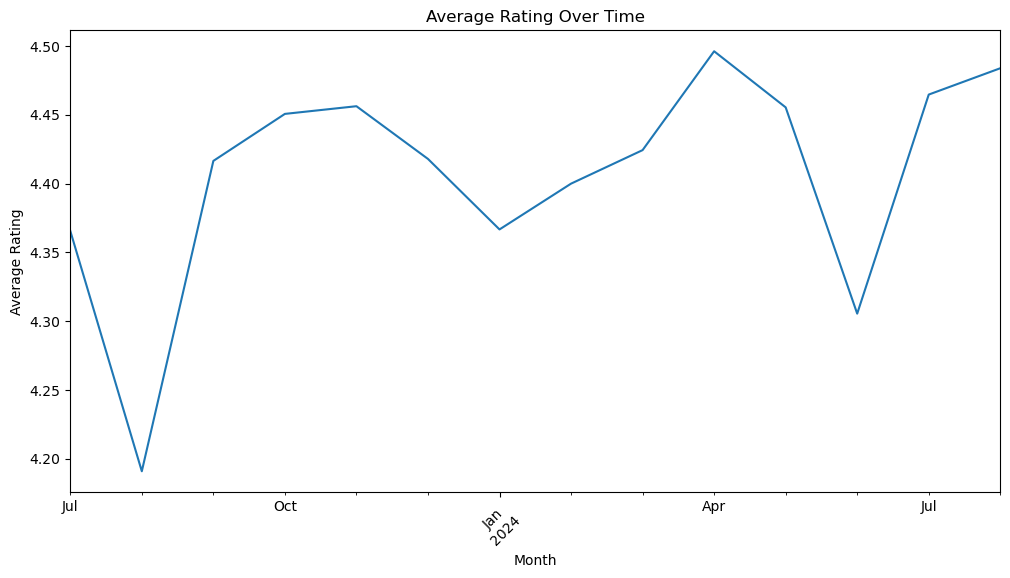

In [19]:
df['Review Date'] = pd.to_datetime(df['Review Date'])

df['month'] = df['Review Date'].dt.to_period('M')

monthly_avg_rating = df.groupby('month')['Ratings'].mean()

plt.figure(figsize=(12, 6))
monthly_avg_rating.plot(kind='line')
plt.title('Average Rating Over Time')
plt.ylabel('Average Rating')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.show()

There is no easily distinguished trend. <br>

**TF-IDF (Term Frequency-Inverse Document Frequency)**

TF-IDF is a statistical measure used to evaluate how important a word is to a document in a collection or corpus.

**Formula:**

$$
\text{TF-IDF}(t, d) = \text{TF}(t, d) \times \text{IDF}(t)
$$

Where:

- **TF (Term Frequency):** Measures how frequently a term \( t \) appears in a document \( d \).

$$
\text{TF}(t, d) = \frac{\text{Number of times term } t \text{ appears in document } d}{\text{Total number of terms in document } d}
$$

- **IDF (Inverse Document Frequency):** Measures the importance of the term \( t \) across all documents. The more documents the term appears in, the less important it is.

$$
\text{IDF}(t) = \log \left( \frac{\text{Total number of documents}}{\text{Number of documents containing } t} \right)
$$

**Interpretation:**
- High **TF-IDF** values indicate words that are both frequent in a particular document but rare across other documents, making them **important** for that document.
- **Low** TF-IDF values indicate words that are common across many documents and are generally less important.

Below we get words with the highest TF-IDF for each rating $i$, where $i \in [5]$

In [20]:
def get_top_tfidf(df, rating, top_n=10):
    reviews = df[df['Ratings'] == rating]['Review']
    
    vectorizer = TfidfVectorizer(max_features=top_n)
    X = vectorizer.fit_transform(reviews)
    
    tfidf_scores = np.asarray(X.sum(axis=0)).flatten()
    words = vectorizer.get_feature_names_out()
    
    tfidf_df = pd.DataFrame(list(zip(words, tfidf_scores)), columns=['Word', 'TF-IDF Score'])
    return tfidf_df.sort_values(by='TF-IDF Score', ascending=False)

top_tfidf = {}
for rating in range(1, 6):
    top_tfidf[rating] = get_top_tfidf(df, rating)

**Plotting the data**

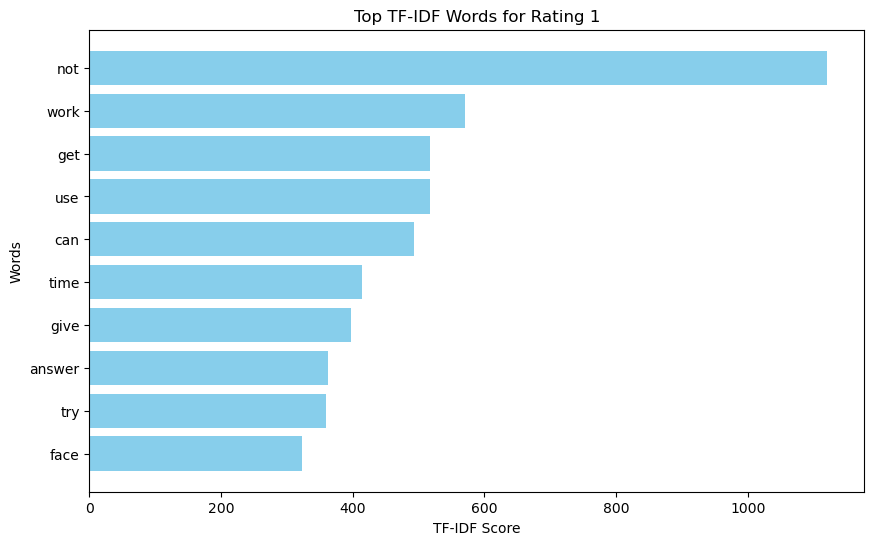

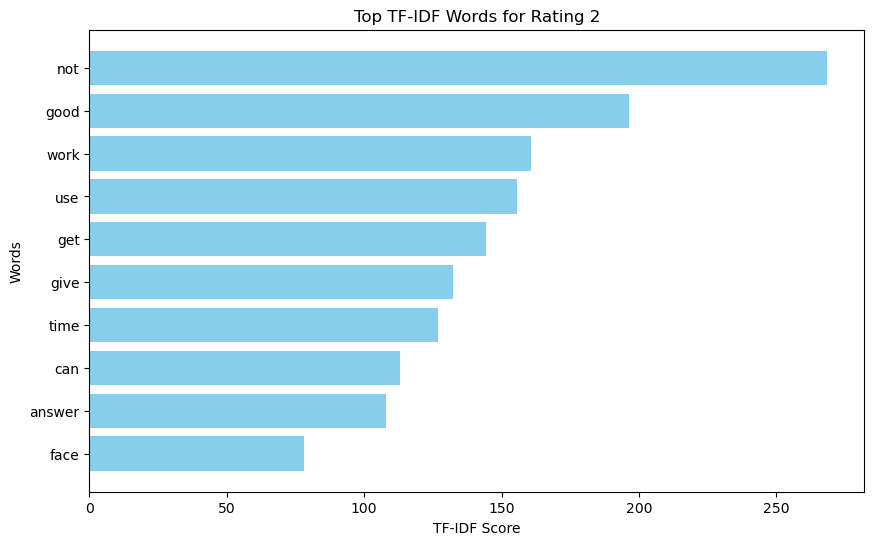

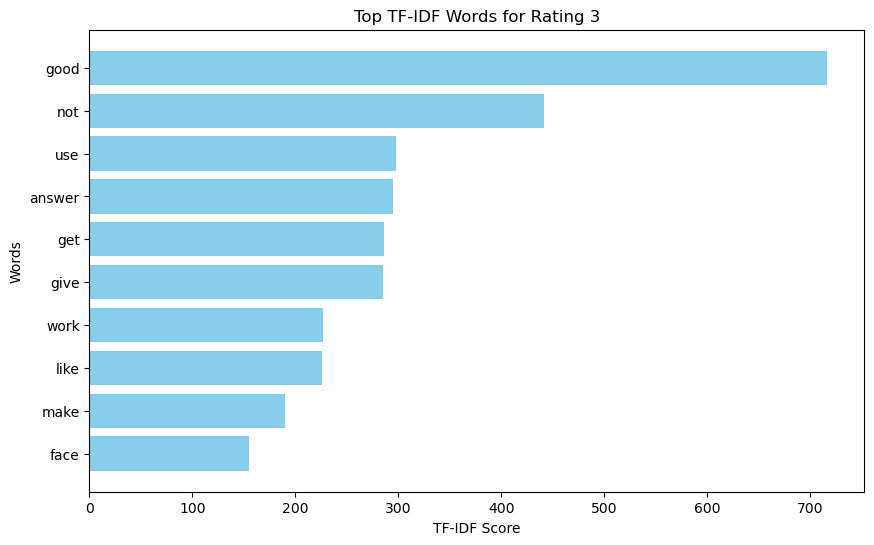

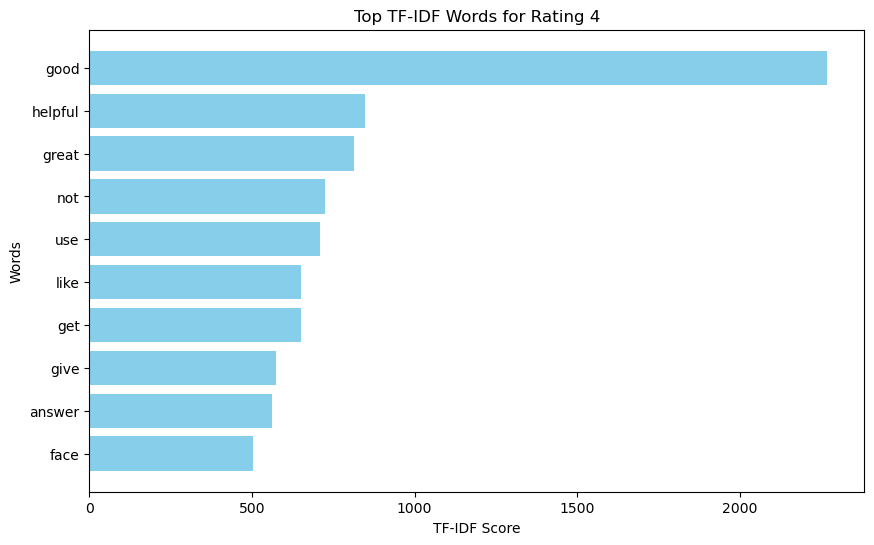

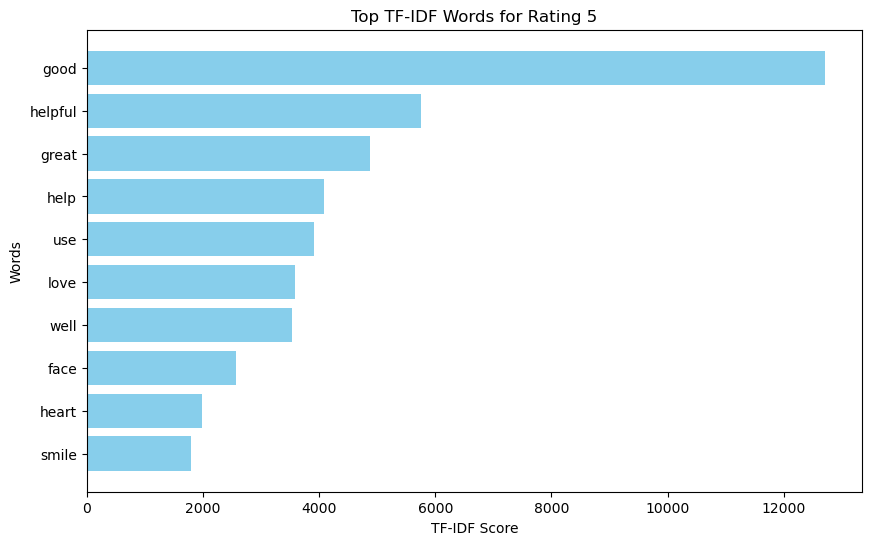

In [21]:
def plot_top_tfidf(top_tfidf):
    for rating in range(1, 6):
        words = top_tfidf[rating]['Word']
        tfidf_scores = top_tfidf[rating]['TF-IDF Score']
        
        plt.figure(figsize=(10, 6))
        plt.barh(words, tfidf_scores, color='skyblue')
        plt.xlabel('TF-IDF Score')
        plt.ylabel('Words')
        plt.title(f'Top TF-IDF Words for Rating {rating}')
        plt.gca().invert_yaxis()
        plt.show()

plot_top_tfidf(top_tfidf)

The results are, again, consistent with intuition. <br>
Now, let's check the dimensionality of the space of unique words.

In [22]:
unique_words = set(" ".join(df['Review'].dropna()).split())

print(len(unique_words))

11510


The dimensionality must be reduced. We will use the PCA algorithm.